# Class 08
## ML Techniques: Outliers



## Unsupervised Learning

Up to this point we have been working with *supervised* learning - we have a set of features and labels (or outputs in the case of a regression) that we used to teach the machine. What if we don't have labels? What if all we have is a set of unlabeled data points? It is still possible to do some types of *unsupervised* machine learning. We'll cover a couple of these methods over the next few classes.

We'll begin with **Outlier Detection**. There are a couple of different ways we can think about outliers:

1. An outlier is a _false_ data point that was erroneously recorded
2. An outlier is a _true_ data point that indicates or records an event that is different than the others and thus of interest

If we are dealing with the first case: the outlier is not real, but was, for example, a mis-recorded or mis-entered number, than the outlier is something we need to **fix**. However, if it is the second case, the outlier may be the thing we are looking for. We'll work with both cases and talk about strategies for dealing with them. Let's first look at how to find the outliers in the data, then we'll look at what to do with them.

I've prepared a sample dataset of fake data with a couple of outliers. Let's load the data and take a look at it graphically.

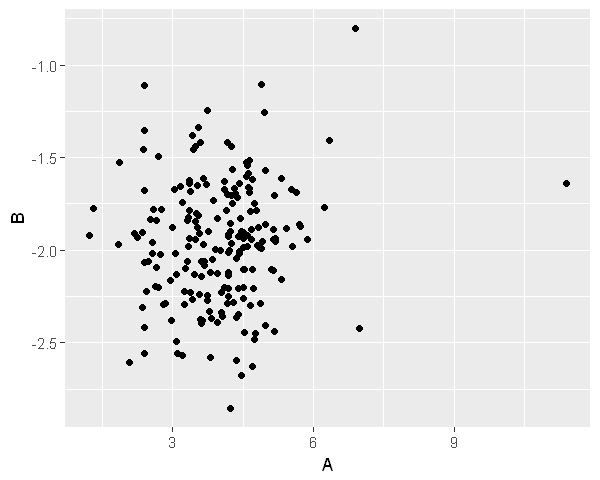

In [65]:
library(ggplot2)
dfa <- read.csv("Class08_fakedata1.csv")

options(repr.plot.width=5, repr.plot.height=4)
ggplot(aes(A,B), data=dfa) + geom_point()

It looks like there are a couple of data points that don't fit in with the rest of the group. Perhaps we can spot them by looking at just the 'A' column data?

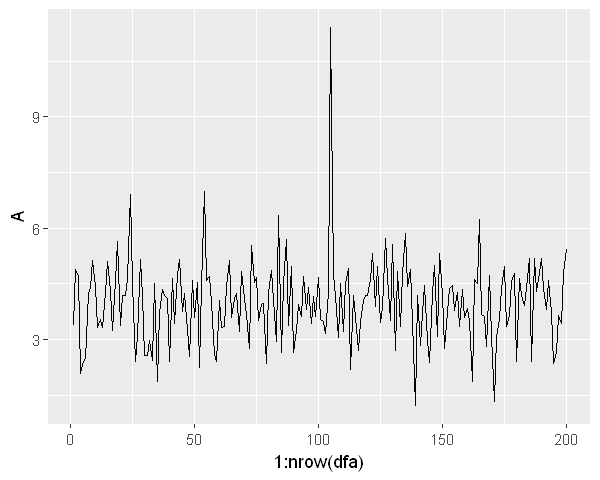

In [66]:
ggplot(aes(x=1:nrow(dfa), y=A),data = dfa) + geom_line()

It looks like one of the points is around the 100 row point. But where is the other? Let's try plotting the 'B' column.

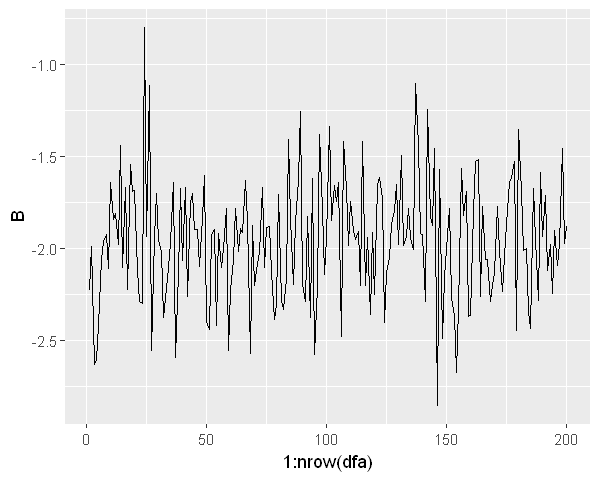

In [67]:
ggplot(aes(x=1:nrow(dfa), y=B),data = dfa) + geom_line()

Well, it isn't clear from this plot that there are any problems in the 'B' column. There is another way we can visualize the data: using a `boxplot`. This type of plot looks at the mean and standard deviation of the data. Then it provides a single plot that shows various limits based on these values. Here's an explanation of the ranges of data used by the boxplot ([explanation from here](http://stackoverflow.com/questions/17725927/boxplots-in-matplotlib-markers-and-outliers)). Any points outside of this range are plotted as separate data points and should be visible.

![Boxplot explanation](Class08_boxplot_limits.png) 

We have to reshape the data in `R` before we can plot it. The `melt` function does this for us, giving us a set of data with each row containing a label that we use as the `x` input for the plot.

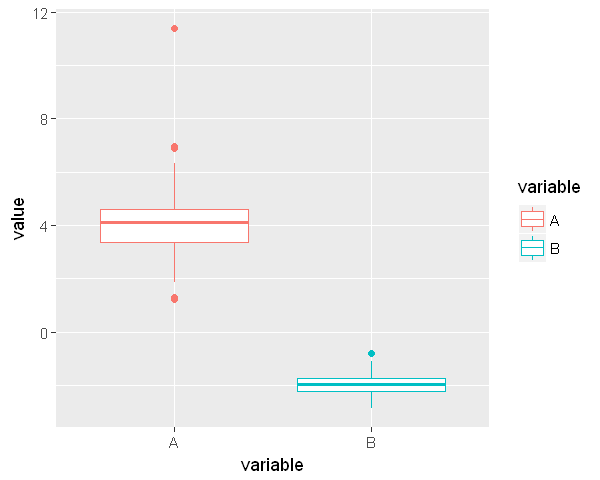

In [68]:
library(reshape2)
dfa.m <- melt(dfa, measure.vars=c('A','B'))

ggplot(dfa.m,aes(x=variable, y=value, color=variable)) + geom_boxplot()

This didn't really help: it maybe spotted an outlier in the 'B' data, but it has way too many in the 'A' data. Let's try going at this another way. We'll start with the 'A' data.

First we'll calculate the mean $\mu$ and standard deviation $\sigma$ for the data. Then we'll scale the data like this: we subtract the mean from each data point $x_i$ and divide by the standard deviation.

$\frac{x_i - \mu}{\sigma}$

This gives us a scaled "distance" between each data point and the mean where the scale is the standard deviation. Let's run this for the 'A' data.

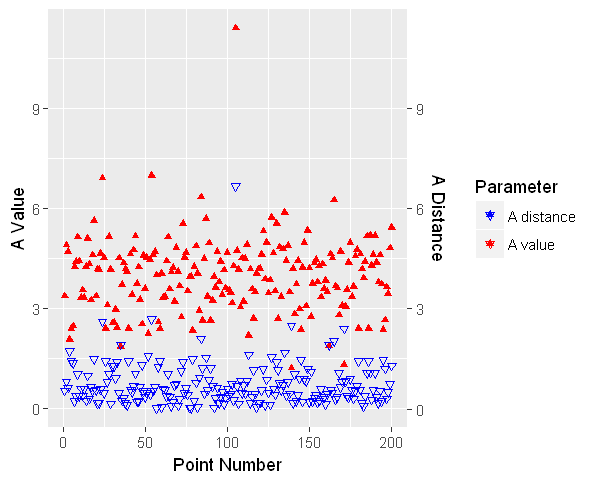

In [69]:
Amean <- mean(dfa$A)
Astdev <- sd(dfa$A)

dfstats <- dfa
# Now calculate the scaled distance (which is always a positive number, so we take the absolute value of the distance)
dfstats$Adist <- abs((dfstats$A - Amean)/Astdev)
ggplot(dfstats,aes(x=1:nrow(dfstats))) + 
    geom_point(aes(y=A, color='A value'),shape=17) +
    geom_point(aes(y=Adist, color='A distance'),shape=25) +
    scale_y_continuous(sec.axis = sec_axis(~., name = "A Distance")) + 
    scale_colour_manual(values = c("blue", "red")) + 
    labs(y = "A Value",
                x = "Point Number",
                colour = "Parameter")

Again, there is one point in the 'A' data that stands out. That is certainly an outlier. But we'd like to use a tool that does this scaling for us and will let us take the 'B' data into consideration, too. Fortunately there is a tool: the Mahalanobis distance [explanation here](https://en.wikipedia.org/wiki/Mahalanobis_distance). The arguments for the `mahalanobis` function [are described here](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/mahalanobis.html).

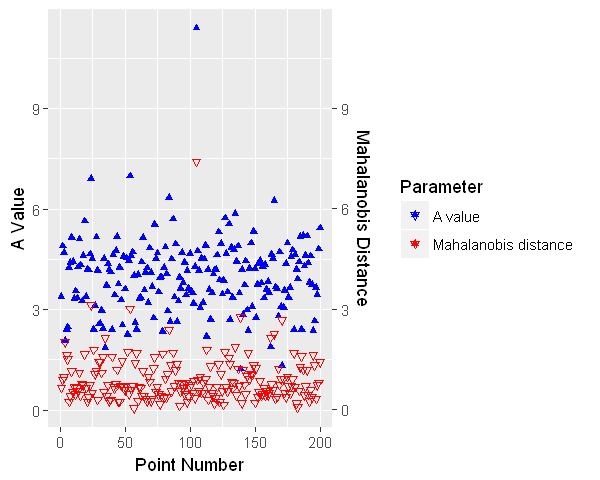

In [85]:
# The Mahalanobis function returns the distance squared, so we take the square root.
dfstats$mdist <- sqrt(mahalanobis(dfa,c(mean(dfa$A),mean(dfa$B)), diag(ncol(dfa))))

ggplot(dfstats,aes(x=1:nrow(dfstats))) + 
    geom_point(aes(y=A, color='A value'),shape=17) +
    geom_point(aes(y=mdist, color='Mahalanobis distance'),shape=25) +
    scale_y_continuous(sec.axis = sec_axis(~., name = "Mahalanobis Distance")) + 
    scale_colour_manual(values = c("blue", "red")) + 
    labs(y = "A Value",
                x = "Point Number",
                colour = "Parameter")

Now we can see there are a couple of points that have a Mahalanobis distance bigger than 4. That's a good indication that they are outlier for this dataset. We can plot the data as a general scatter plot and then overlay contour lines for the different Mahalanobis distances from the mean. That will let us see how the distances compare.

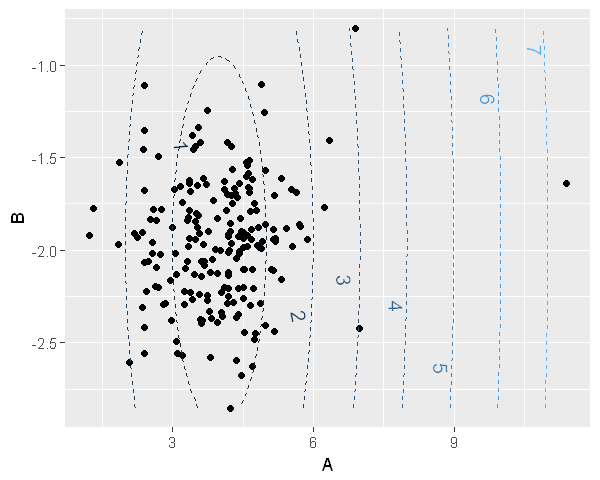

In [120]:
library(pracma)
library(directlabels)
myPlot <- ggplot(aes(A,B), data=dfa) + geom_point()

# Get a mesh
mesh<-meshgrid(seq(layer_scales(myPlot)$x$range$range[1],layer_scales(myPlot)$x$range$range[2],length=100),
               seq(layer_scales(myPlot)$y$range$range[1],layer_scales(myPlot)$y$range$range[2],length=100))
meshdf <- data.frame(XX=c(mesh$X),YY=c(mesh$Y))

meshdf$dist <- sqrt(mahalanobis(meshdf,c(mean(dfa$A),mean(dfa$B)), diag(ncol(meshdf))))

myPlot <- myPlot + geom_contour(data=meshdf,aes(XX,YY,z=dist,colour = ..level..),linetype=2,binwidth=1)
direct.label(myPlot, list("far.from.others.borders", "calc.boxes", "enlarge.box", 
      hjust = 1, vjust = 1, box.color = NA, fill = "transparent", "draw.rects"))

Now we can see that there are a couple of points with a distance bigger than 3. This cutoff is slightly arbitrary- we choose how big or small we want to make it depending on the data and what we are doing with it. For now, we'll set the cutoff distance and then create a cleaned dataset where the distances are less than this cutoff.

In [124]:
cutoff_distance <- 3.0
dfclean <- dfstats[dfstats$mdist < cutoff_distance,]
print(paste0("Initial number of points: ",nrow(dfa)))
print(paste0("Cleaned number of points: ",nrow(dfclean)))

[1] "Initial number of points: 200"
[1] "Cleaned number of points: 197"


# TODO START HERE

### Outlier Category

Instead of removing the points, we could label them or otherwise mark them. We'll do this by creating a True-False categorical column that marks the potential outliers as True.

In [10]:
dfa['outlier'] = (dfa['dist'] > cutoff_distance).astype('category')
print(dfa.dtypes)
dfa.head()

A           float64
B           float64
dist        float64
outlier    category
dtype: object


,A,B,dist,outlier
0,3.379122,-2.227508,0.946078,False
1,4.895166,-1.991730,0.838179,False
2,4.704226,-2.630269,2.221110,False
3,2.069320,-2.607981,2.497841,False
4,2.400303,-2.419060,1.906594,False


## Functional Outlier Detection


So that first set of data was fairly easy to work with: the distribution of data points looked Gaussian (it was) and so the outliers were easy to detect using methods that depend on normal distributions. What if our data aren't normally distributed? Let's look at another fake dataset that has a couple of outliers.

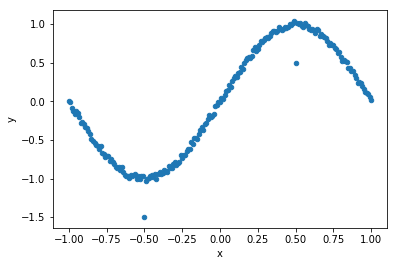

In [11]:
dfb = pd.read_csv("Class08_fakedata2.csv")
dfb.plot.scatter(x='x',y='y')

We can clearly see that there are two points that don't fit the pattern. How do we identify them? We could try a boxplot.

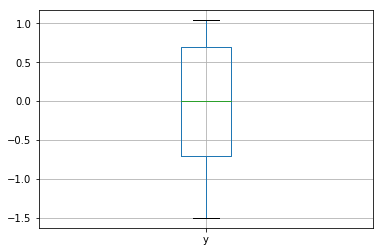

In [12]:
dfb.boxplot('y')

That doesn't get us anywhere. How about trying the Mahalanobis distance?

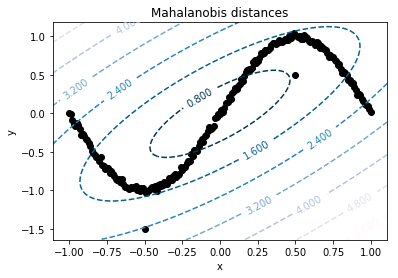

In [13]:
xy=dfb[['x','y']].values
emp_covxy = EmpiricalCovariance().fit(xy)
mahal_distxy = np.sqrt(emp_covxy.mahalanobis(xy))

trainfig, ax = plt.subplots()
ax.scatter(dfb['x'].values,dfb['y'].values,color='black')
ax.set_title("Mahalanobis distances")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_covxy.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = ax.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')
ax.clabel(emp_cov_contour, inline=1, fontsize=10)
ax.set_xlabel('x')
ax.set_ylabel('y')

That isn't helpful, either. We need a new technique. We'll start by creating a machine learning model to predict the data. In this case we'll use a support vector regression. It should be weighted to try and fit the majority of the data which look like they are good. We'll also print out the `score` for the model fit. This is the accuracy score that we've used before.

Score: 0.9870568575200664


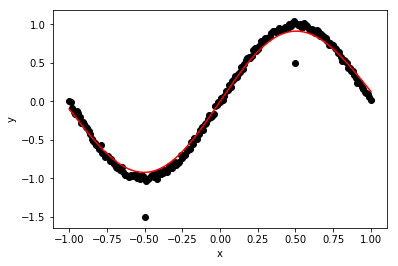

In [14]:
from sklearn.svm import SVR
svrmodel = SVR()
svrmodel.fit(dfb['x'].values.reshape(-1,1), dfb['y'].values)

X_plot =np.linspace(-1, 1, 1000)
Y_pred = svrmodel.predict(X_plot[:,None])

fig, ax = plt.subplots()
# First plot our points
ax.scatter(dfb['x'].values,dfb['y'].values,color='black')
ax.plot(X_plot,Y_pred,c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')

print("Score: {}".format(svrmodel.score(dfb['x'].values.reshape(-1,1),dfb['y'].values)))

Like we hoped, the model looks like it follows most of the data. Now we can look to see if we can find those outliers. We'll plot the model predictions against the actual `y` values.

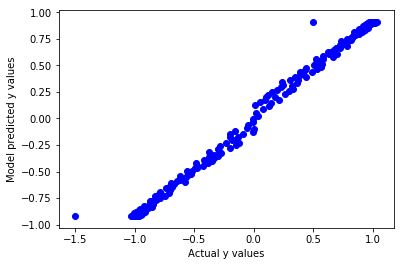

In [15]:
pred = svrmodel.predict(dfb['x'].values.reshape(-1,1))
plt.scatter(dfb['y'].values,pred,color='blue')
plt.xlabel('Actual y values')
plt.ylabel('Model predicted y values')

If the model prediction matches the actual value, the data point lies on a line with a slope of `1`. We see that most of the data points are on that line! And there are two points that are off the line - those are our outliers. Another way to visualize this is to calculate the **residuals**: the difference between the actual `y` values and the predicted `y` values. We'll create a new column of the residuals and plot them.

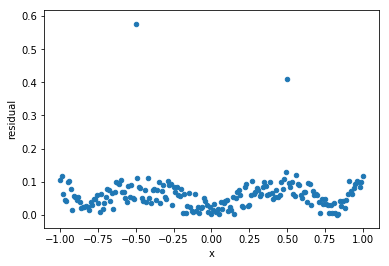

In [16]:
dfb['residual'] = np.abs(dfb['y'].values - pred)

dfb.plot.scatter(x='x',y='residual')

Now we can sort the data by the residual column and look for the largest values.

In [17]:
dfb.sort_values('residual',ascending=False).head()

,x,y,residual
50,-0.50,-1.500000,0.577333
150,0.50,0.500000,0.411061
149,0.49,1.038593,0.128300
156,0.56,1.017611,0.119498
1,-0.99,-0.007512,0.117681


Now we'll create a new dataset where we select only the data where the residuals are less than a threshold value. We'll try fitting this data to see if our model has improved without the outliers.

Score: 0.9896101260044042


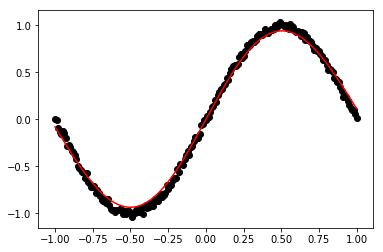

In [18]:
threshold = 0.3

dfbcl = dfb[dfb['residual'] <= threshold]

svrmodel2 = SVR(C=10,gamma=1)
svrmodel2.fit(dfbcl['x'].values.reshape(-1,1), dfbcl['y'].values)

Y_pred = svrmodel2.predict(X_plot[:,None])

fig, ax = plt.subplots()
# First plot our points
ax.scatter(dfbcl['x'].values,dfbcl['y'].values,color='black')
ax.plot(X_plot,Y_pred,c='r')
print("Score: {}".format(svrmodel2.score(dfb['x'].values.reshape(-1,1),dfb['y'].values)))

It looks like the score went up a little bit and the model looks a little better. Certainly we don't have those outliers any more!

## In-class Activity

Take a look at the fake data in `Class08_fakedata3.csv`. There are 3 outlier points. Find them and check with me to see if you found them.

## Assignment

You may or may not have outliers in your data. Check and see and report on what you found (if anything).